In [ ]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance, reduce_min, reduce_max
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from utils.basic_units import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [ ]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [ ]:
k = 10 # Top 10% highest l2-magnitude filters

In [ ]:
def get_F_angle(F):
	
	F = tf.expand_dims(F, -1)
	_, a = getSymAntiSymTF(F)
	a_mag = reduce_euclidean_norm(a, axis=[0,1])[:, 0]
	print(a_mag.shape)
	theta = getSobelTF(F)[:, 0]
	#print(a_mag.shape)
	x =a_mag*np.cos((theta))
	y = a_mag*np.sin((theta))


	cov = np.cov([x,y])
	e_val, e_vec = np.linalg.eig(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)
	if e_vec[1] <0:
		pass
		#print("DOWN", e_vec)
	'''if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
		e_vec *= -1'''
		#print(e_val, e_vec)
	#print(np.arctan2(e_vec[1], e_vec[0]))
	return np.arctan2(e_vec[1], e_vec[0])

In [ ]:
def rejection_sampling(X, Y, n_samples ):
    from scipy.stats import gaussian_kde


    # Range of X
    X_min, X_max = 0, 1

    # Estimate the empirical density of X using KDE
    kde = gaussian_kde(X)
    proposal_density = kde(X)

    # Target is uniform, so the density is constant over the range
    target_density = np.ones_like(X) / (X_max - X_min)

    # Calculate importance weights
    weights = target_density / proposal_density

    # Normalize weights
    weights /= np.sum(weights)

    # Resample based on the weights
    idx = np.random.choice(np.arange(len(X)), size=n_samples, p=weights)
    print(idx)
    return np.array(X)[idx], np.array(Y)[idx]

In [ ]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)

 
l_num = -2
#top10Fprev=topKfilters(model, l_num-1, k=100)
filtersLprev = get_filter(model, l_num-1)
#top10F=topKfilters(model, l_num, k=100)
filtersL = get_filter(model, l_num)
filtersL = filtersL


print("FL", filtersL.shape)

# Get kernels magnitude and theta for layer L-1
sp, ap = getSymAntiSymTF(filtersLprev)
e_ap = reduce_euclidean_norm(ap, axis=[0,1])**2
e_sp = reduce_euclidean_norm(sp, axis=[0,1])**2
betap = e_ap/(e_ap+e_sp)


# Get kernels magnitude and theta for layer L
s, a = getSymAntiSymTF(filtersL)
e_a = reduce_euclidean_norm(a, axis=[0,1])**2
e_s = reduce_euclidean_norm(s, axis=[0,1])**2
dc = np.sign(np.mean(filtersL, axis=(0,1)))

beta = e_a/(e_a+e_s)



mag = reduce_euclidean_norm(filtersL, axis=[0,1])

theta = getSobelTF(filtersL)
 
mag = (mag - reduce_min(mag, axis=0, keepdims=True))/(reduce_max(mag, axis=0, keepdims=True) - reduce_min(mag, axis=0, keepdims=True))

print("AMAG", mag.shape)


#find lims :
cos_sim = []
m = []
weight = []
for i in range(filtersLprev.shape[-1]):
	print(i)
	theta_F_prev = get_F_angle(filtersLprev[:,:,:,i])
	
	cos_sim.extend(theta_F_prev - theta[i,:])#(np.cos(theta_F_prev - theta[i,:])))
	m.extend(mag[i, :].numpy()*dc[i,:])
	weight.extend(beta[i, :] * tf.reduce_mean(betap[:, i]))
weight = np.array(m)
m = np.array(m)




'''print("M", len(m))
m, t= rejection_sampling(m, cos_sim, 5000)
print(cos_sim)'''
#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)

fig, ax= plt.subplots(1,1)

data = np.array(cos_sim)
data  = np.arctan2(np.sin(data), np.cos(data)) # (np.array(cos_sim) + np.pi) % (2 * np.pi) - np.pi
ax.hist2d(data,m, bins=16)#, weights=weight)
print(ax.get_xlim())
data_min, data_max = np.min(data), np.max(data)

# Set the tick marks at intervals of π
tick_min = np.floor(data_min / np.pi) * np.pi  # Start at the lowest multiple of π
tick_max = np.ceil(data_max / np.pi) * np.pi    # End at the highest multiple of π
ticks = np.arange(tick_min, tick_max + np.pi, np.pi)  # Ticks spaced by π
print(tick_min)
# Format tick labels with π notation
labels = [f"{int(t / np.pi)}π" if t != 0 else "0" for t in ticks]
labels = [label.replace("π", "$\\pi$").replace("1$\\pi$", "$\\pi$") for label in labels]
print(labels)
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels)




#ax.convert_xunits(radians)
ax.set_ylabel(r"$\cdot ||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)
ax.set_title(f"Layer {l_num}"+r"$\rightarrow$"+f"{l_num+1}")


plt.show() 


NameError: name 'model' is not defined

<BarContainer object of 16 artists>

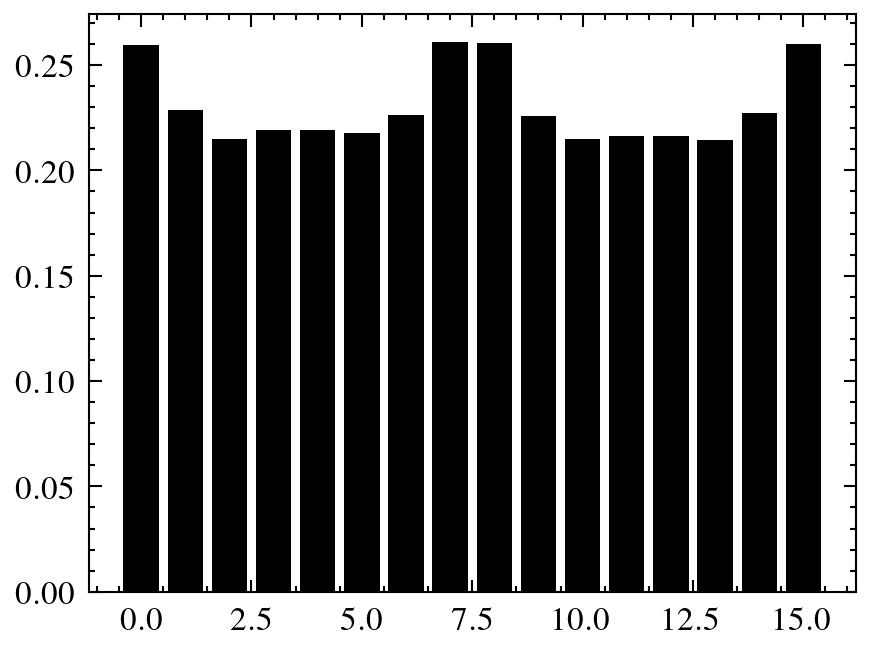

In [ ]:

vals = ax.hist2d(data,m, bins=16, weights=m)
unweighted_vals = ax.hist2d(data,m, bins=16)

w_counts = vals[0]

uw_counts = unweighted_vals[0]

sum_intensities = tf.reduce_sum(w_counts, axis=1)/tf.reduce_sum(uw_counts, axis=1)
#plt.bar(sum_intensities, vals[1])
vals[1].shape
plt.bar(list(range(16)), sum_intensities)

(array([7714.00585938, 3615.17382812, 2283.03027344, 2106.04467773,
        2150.40478516, 2323.98901367, 3528.53442383, 7648.17919922,
        7703.86669922, 3552.34204102, 2317.99560547, 2056.15356445,
        2054.55639648, 2356.40551758, 3548.46582031, 7610.77050781]),
 array([-3.1415920e+00, -2.7488935e+00, -2.3561950e+00, -1.9634964e+00,
        -1.5707979e+00, -1.1780993e+00, -7.8540075e-01, -3.9270222e-01,
        -3.6954880e-06,  3.9269483e-01,  7.8539336e-01,  1.1780919e+00,
         1.5707905e+00,  1.9634891e+00,  2.3561876e+00,  2.7488861e+00,
         3.1415846e+00], dtype=float32),
 <BarContainer object of 16 artists>)

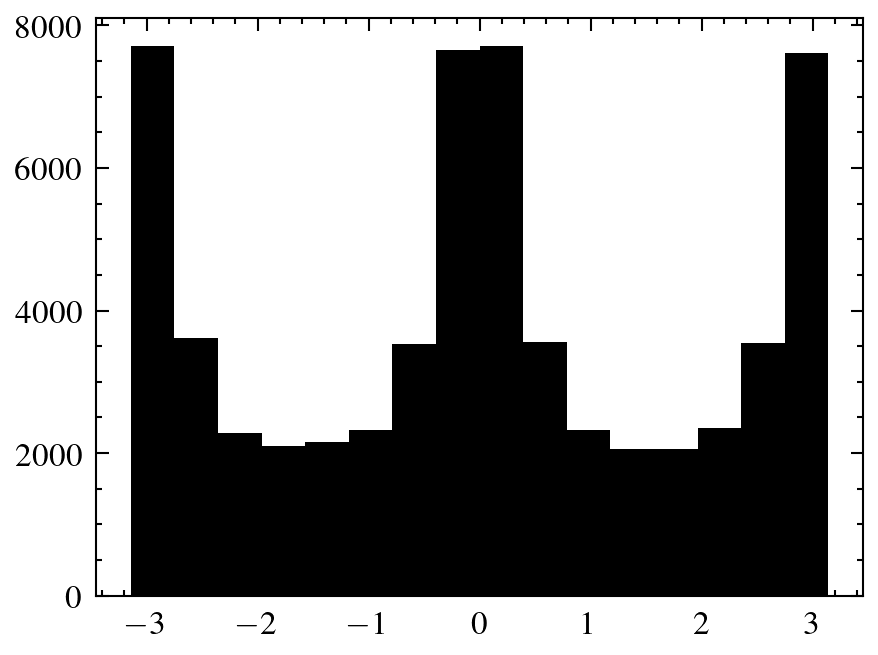

In [ ]:
plt.hist(data, bins=16, weights=m)

(array([29708., 15822., 10631.,  9619.,  9808., 10672., 15589., 29294.,
        29586., 15738., 10786.,  9513.,  9496., 10978., 15619., 29285.]),
 array([-3.1415920e+00, -2.7488935e+00, -2.3561950e+00, -1.9634964e+00,
        -1.5707979e+00, -1.1780993e+00, -7.8540075e-01, -3.9270222e-01,
        -3.6954880e-06,  3.9269483e-01,  7.8539336e-01,  1.1780919e+00,
         1.5707905e+00,  1.9634891e+00,  2.3561876e+00,  2.7488861e+00,
         3.1415846e+00], dtype=float32),
 <BarContainer object of 16 artists>)

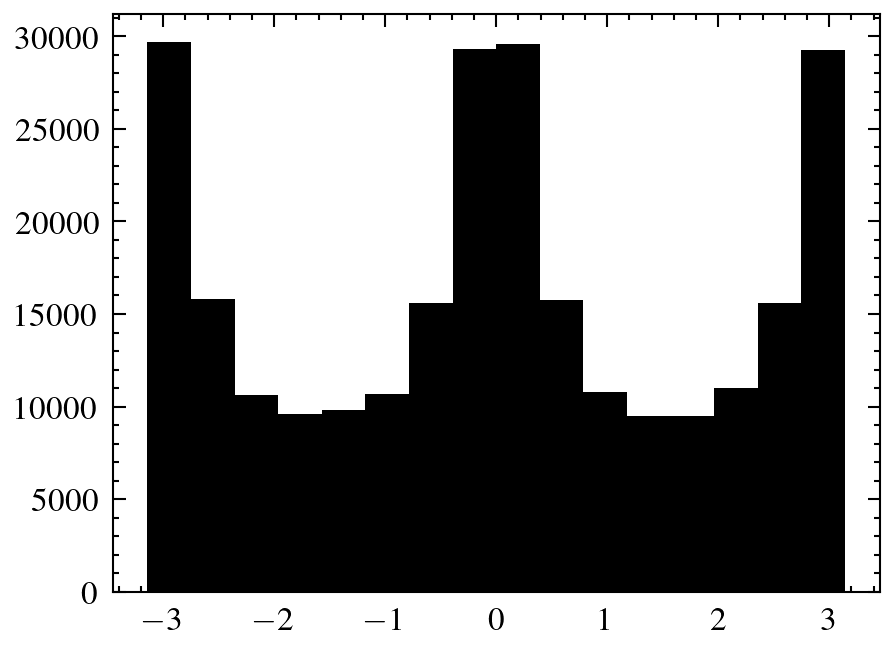

In [ ]:
plt.hist(data, bins=16)

In [ ]:
weight.shape

(262144,)

(array([7714.00585938, 3615.17382812, 2283.03027344, 2106.04467773,
        2150.40478516, 2323.98901367, 3528.53442383, 7648.17919922,
        7703.86669922, 3552.34204102, 2317.99560547, 2056.15356445,
        2054.55639648, 2356.40551758, 3548.46582031, 7610.77050781]),
 array([-3.1415920e+00, -2.7488935e+00, -2.3561950e+00, -1.9634964e+00,
        -1.5707979e+00, -1.1780993e+00, -7.8540075e-01, -3.9270222e-01,
        -3.6954880e-06,  3.9269483e-01,  7.8539336e-01,  1.1780919e+00,
         1.5707905e+00,  1.9634891e+00,  2.3561876e+00,  2.7488861e+00,
         3.1415846e+00], dtype=float32),
 <BarContainer object of 16 artists>)

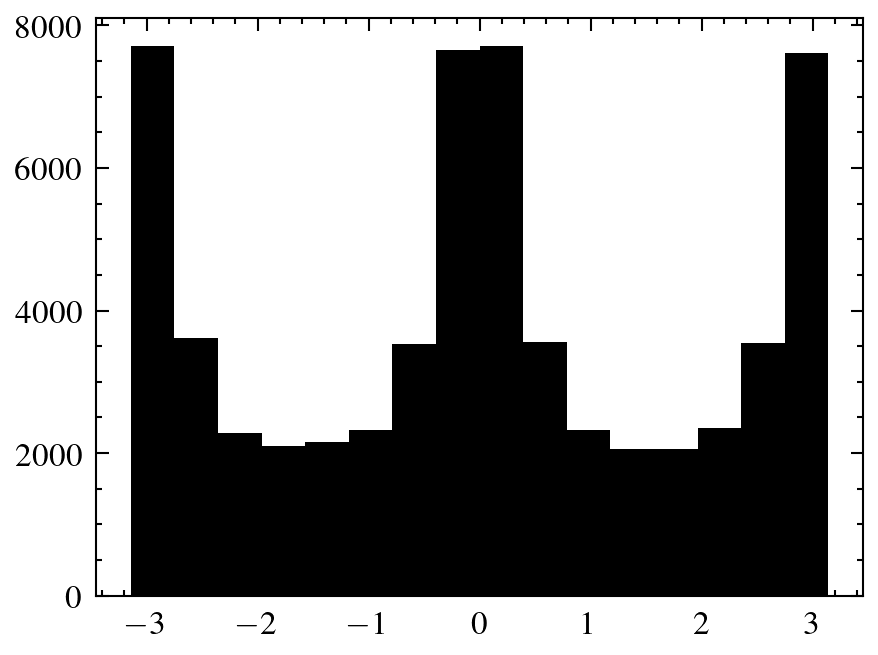

In [ ]:
plt.hist(data, bins=16, weights=weight)